# Simulate the feedforward network including ISP!

In [1]:
import numpy as onp
from jax import numpy as np
from jax import random, vmap, jit
from jax.lax import scan, clamp
from jax.ops import index_min, index_update
from jax.numpy import clip

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("colorblind")
sns.set_context("poster")

In [2]:
# Parameters
p = {'vrest': -60.0, 'vth': -50.0, 'tref': 5.0,
         'gleak': 1.0, 've': 0.0, 'vi': -80.0,
         'te': 5.0, 'ti': 10.0, 'tau': 20.0}
dt = 1.0

In [3]:
def step(p, states, xt):
    """
    xt: exc. and inh spikes
    """
    v, spike, tspike, ge, gi, t, = states # ((1, ); (1,), (Ne, ); (Ni, ))
    spike = np.where(v >= p['vth'], 1.0, 0.0)
    tspike = np.where(spike==1.0, t, tspike)
    
    ge = (1 - dt / p['te']) * ge + xt[0]#xt['e'] # * weight
    gi = (1 - dt / p['ti']) * ge + xt[1] #xt['i'] # * weight
    dvdt = (p['vrest'] - v) + 1/p['gleak'] * (ge.sum() * (p['ve'] - v) + gi.sum() * (p['vi']- v) + 0)
    v = np.where(t - tspike <= p['tref'], p['vrest'], v + dt / p['tau'] * dvdt)
    states =  v, spike, tspike, ge, gi, t+1
    return states, states

def gen_init_states(params):
    v = np.ones((1, )) * params['vrest']
    spike = np.zeros((1, )) * 1.0
    tspike = np.ones((1,)) * -np.inf
    ge = np.ones((1, )) * 1.0
    gi = np.zeros((1, )) * 1.0
    t = 0.0
    return v, spike, tspike, ge, gi, t

def lif_neuron(params, x):
    init_states = gen_init_states(params)
    _, states = scan(lambda s, x: step(params, s, x), init_states, x)
    return states

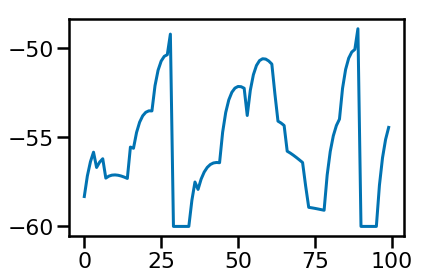

In [4]:
x = onp.random.choice([0,1], p=[0.9, 0.1], size = (100, 2))# np.ones((100, 2))
states = lif_neuron(p, x)
plt.plot(states[0])

Multiple neurons

In [5]:
def make_exc_weights(Ne = 100):
    ge = 140 # pS
    K = np.arange(1, 9)
    P = 5
    Wgroups = 0.3 + 1.1 / (1 + (K - P)**4)
    W = np.repeat(Wgroups, Ne)
    eps = onp.random.uniform(0, 0.1, size=W.shape[0])
    W += eps
    return Wgroups, W

In [23]:
def step(p, states, xt):
    """
    xt: exc. and inh spikes
    """
    v, spike, tspike, ge, gi, t, = states # ((1, ); (1,), (Ne, ); (Ni, ))
    spike = np.where(v >= p['vth'], 1.0, 0.0)
    tspike = np.where(spike==1.0, t, tspike)
    print(xt[0].shape)
    
    ge = (1 - dt / p['te']) * ge + xt[0]
    gi = (1 - dt / p['ti']) * gi + xt[1] # TO DO: Ni< Ne
    dvdt = (p['vrest'] - v) + 1/p['gleak'] * (np.dot(ge, We) * 0.1 * (p['ve'] - v) + np.dot(gi, Wi) * (p['vi']- v) + 0)
    v = np.where(t - tspike <= p['tref'], p['vrest'], v + dt / p['tau'] * dvdt)
    states =  v, spike, tspike, ge, gi, t+1
    return states, states

def gen_init_states(params):
    v = np.ones((1, )) * params['vrest']
    spike = np.zeros((1, )) * 1.0
    tspike = np.ones((1,)) * -np.inf
    ge = np.zeros((Ne * n_groups, )) * 1.0
    gi = np.zeros((Ne * n_groups, )) * 1.0
    t = 0.0
    return v, spike, tspike, ge, gi, t

def lif_neuron(params, x):
    init_states = gen_init_states(params)
    _, states = scan(lambda s, x: step(params, s, x), init_states, x)
    return states

lif_neuron_jit = jit(lif_neuron)

(800,)


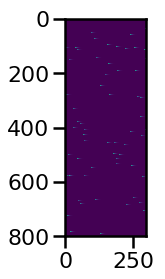

In [7]:
Ne = 100
time_steps = 300
n_groups = 8
Wgroups, We = make_exc_weights(Ne)
Wi = np.zeros((Ne * n_groups, ))
x = onp.random.choice([0,1], p=[0.999, 0.001], size = (time_steps, 2, Ne * 8))# np.ones((100, 2))
# Turn into timesteps dict
states = lif_neuron(p, x)
plt.imshow(states[3].T)

Add weights. 

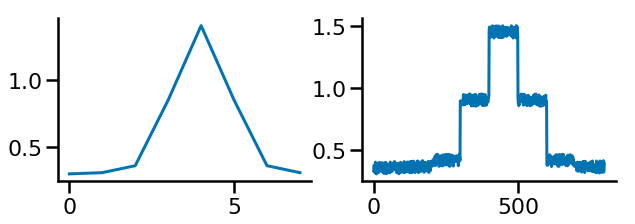

In [8]:
f, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(Wgroups)
ax[1].plot(We)
sns.despine()

# Use generated rates

In [9]:
import sys
sys.path.append("../src/")
from data_utils import ou_process_jit
import data_utils

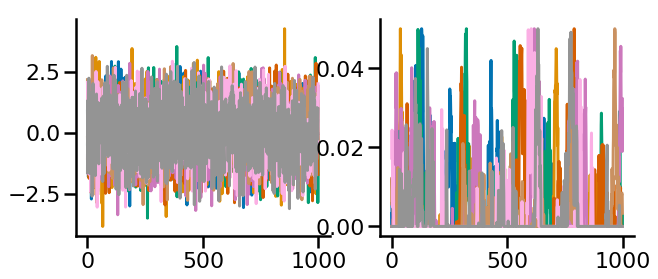

In [10]:
params = {'mu': -2, 'tau': 20.0, 'sigma': 1.0} # dt in ms
# Adust mean and tau to get 

seed = onp.random.randint(1e6)
key = random.PRNGKey(seed)
keys = random.split(key, n_groups+1)[1:]
time_steps = 1000
xs, ys, spikes = data_utils.ou_process_jit(params, time_steps, Ne * 2, keys) # Exc and inh.
#ys *= 0.005
f, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(xs.T);
ax[1].plot(ys.T);
sns.despine()

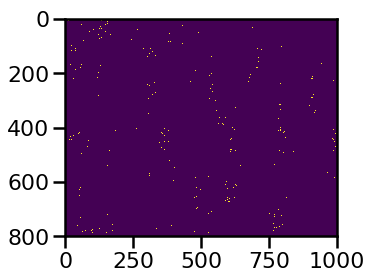

In [11]:
xe = spikes[:,:Ne].reshape((-1, time_steps)).T
xi = spikes[:,Ne:].reshape((-1, time_steps)).T
x = np.concatenate((xe[:,None], xi[:,None]), 1) #(time steps, 2, neurons)
plt.imshow(xe.T)

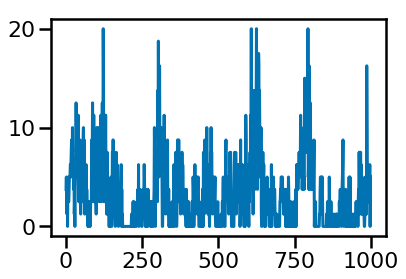

In [12]:
plt.plot(xe.mean(1) * 10**3)

71.0


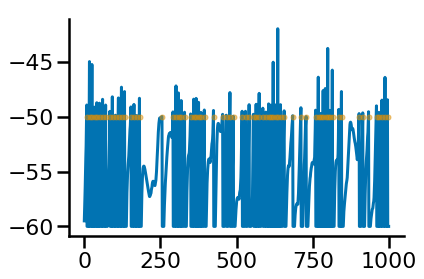

In [25]:
states = lif_neuron_jit(p, x)
v, spike, tspike, ge, gi, t = states
print(spike.sum())
plt.plot(v[:,0])
spike_times = np.where(spike)[0]
plt.plot(spike_times, np.ones((len(spike_times), )) * -50, 'o', markersize=5, alpha=0.5)
sns.despine()